In [275]:
import os, scipy, sklearn, spacy, glob
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
from helpers import *
import html2text
import markdown
from bs4 import BeautifulSoup
from scipy.spatial.distance import cdist, pdist, squareform
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as sw

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
fileid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
datadir = '../data'
fname = os.path.join(datadir, 'data.csv')

if not os.path.exists(datadir):
    os.makedirs(datadir)
    
if not os.path.exists(fname):
    print('Fetching file from the interwebz!')
    dl(fileid, fname)
else:
    print('Data found!')

Data found!


In [3]:
data = pd.read_csv(fname)

In [4]:
data.head()

,id,title,url,writers,genres,script
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...


## Plot trajectories of movies in topic space

##### Problem: now each movie gets its own dimensionality reduction (from 100 to 2) => not in common space. Therefore apply ndim=2 at the moment of fitting the semantic model.

##### That doesn't seem to work... instead, run the model with 100 topics and then run a joint dimensionality reduction (PCA) on both movies

##### This might work! So let's pick 2 movies that are very similar (e.g. both comedies about the same topic) and one that's probably very different:

In [5]:
genres = ['Sci-Fi','Comedy','Drama','Adventure']
titles_by_genre = {}
for genre in genres:
    genre_titles = []
    for ri,row in data.iterrows():
        if genre in row['genres']:
            genre_titles.append(row['title'])
    titles_by_genre[genre] = genre_titles

In [6]:
titles = [titles_by_genre['Sci-Fi'][10:13],
          titles_by_genre['Comedy'][10:13]]
movie_ids = []
for title in titles:
    print(title)
    [movie_ids.append(a) for a in list(data.query('title == @title').id.values)]
print(movie_ids)

['Alien Nation', 'Alien vs. Predator', 'Alien: Resurrection']
['Addams Family, The', 'Adventures of Buckaroo Banzai Across the Eighth Dimension, The', 'After School Special']
[44, 45, 46, 30, 32, 34]


##### Grab all movie trajectories

In [234]:
# results = dict()
window_size = 25
n_components = 100
for mi, movie_id in enumerate(movie_ids):
    print('analyzing movie %i'%movie_id)
    sliding_windows = get_windows(data.query('id == @movie_id')['script'].values[0],
                                  wsize=window_size)
    topics_wiki = hyp.tools.format_data(sliding_windows, corpus='wiki',
      semantic={'model':'LatentDirichletAllocation',
        'params':{'n_components' : n_components}},
      vectorizer={'model':'CountVectorizer',
          'params':{'stop_words':sw.words('english')}})
    results['movie_%i'%movie_id] = {'movie_id':movie_id,
                                   'topics_wiki':topics_wiki[0]}

analyzing movie 44
analyzing movie 30


In [439]:
movie_ids = [list(results.keys())[i][6:] for i in range(len(results))]
titles = [data.loc[data['id']==int(movie_id),'title'].values[0] for movie_id in movie_ids]
print(movie_ids)
print(titles)

['42', '43', '19', '1', '44', '30']

In [441]:
# Append all
for mi, movie_id in enumerate(movie_ids):
    topics_wiki = results['movie_%s'%movie_id]['topics_wiki']
    if mi == 0:
        total_trajectory = topics_wiki
    else:
        total_trajectory = np.append(total_trajectory,topics_wiki,axis=0)

In [442]:
PCA = sklearn.decomposition.PCA(n_components=3)

In [443]:
PCA.fit(total_trajectory)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [445]:
transforms = dict()
for mi, movie_id in enumerate(movie_ids):
    transforms['movie_%s'%movie_id] = PCA.transform(results['movie_%s'%movie_id]['topics_wiki'])

Text(0.5,1,'Movies in wikipedia topic space')

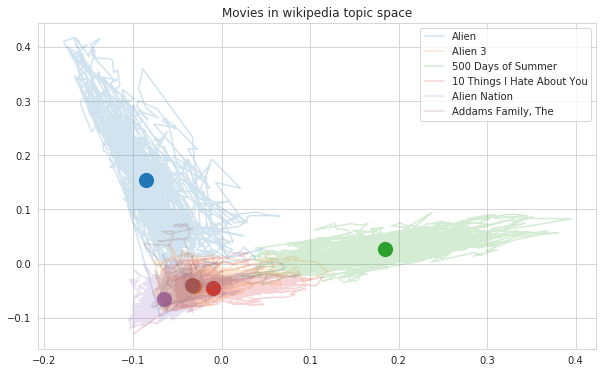

In [471]:
colors = sns.color_palette('tab10',len(movie_ids))
fig = plt.figure(figsize=[10,6])
for mi, movie_id in enumerate(movie_ids):
    dat = transforms['movie_%s'%movie_id]
    plt.plot(dat[:,0],dat[:,1],
            c=colors[mi], alpha = .2)
    plt.scatter(np.mean(dat[:,0]),np.mean(dat[:,1]),
                s=200,c=colors[mi],marker='o')
plt.legend(titles)
plt.title('Movies in wikipedia topic space')

## Use spacy to compute text similarity

In [7]:
nlp = spacy.load('en_core_web_lg')

In [74]:
data.query('id > 25')[['id','title']]

,id,title
25,26,Absolute Power
26,27,"Abyss, The"
27,28,Ace Ventura: Pet Detective
28,29,Adaptation
29,30,"Addams Family, The"
30,31,"Adjustment Bureau, The"
31,32,Adventures of Buckaroo Banzai Across the Eight...
32,33,Affliction
33,34,After School Special
34,35,After.Life


In [284]:
script_vectors = pd.DataFrame()
movie_ids = np.arange(50,100)
dat_use = data.loc[data['id'].isin(movie_ids)].copy()
titles = dat_use['title']
docs = {}
for mi,movie in dat_use.iterrows():
    doc = nlp(wipe_formatting(u"%s"%movie['script']))
    docs[movie['id']] = doc
    vec = pd.DataFrame(doc.vector).T
#     vec.set_index(movie['id'])
    script_vectors = script_vectors.append(vec)
script_vectors = script_vectors.reset_index(drop=True)

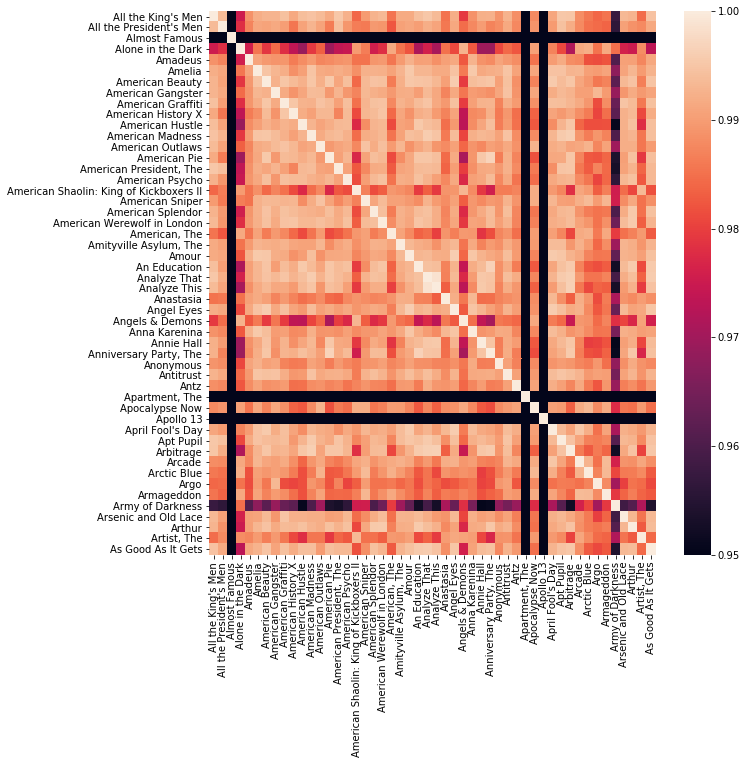

In [288]:
include = range(np.shape(script_vectors)[0])
titles_include = [titles.values[i] for i in include]
fig,ax = plt.subplots(1,1,figsize=[10,10])
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(
    script_vectors.iloc[include,:]),vmin = 0.95,
            xticklabels = titles_include, yticklabels = titles_include,
           ax=ax)

In [135]:
alien = docs[42]

In [136]:
[print((i,list(alien.ents)[i])) for i in np.arange(10)]

(0, Dan O'Bannon ALIEN)
(1, STARBEAST)
(2, Dan O'Bannon &)
(3, Ronald Shusett)
(4, Dan O'Bannon)
(5, Earth)
(6, only one)
(7, only six hours)
(8, Earth)
(9, CHAZ STANDARD)


[None, None, None, None, None, None, None, None, None, None]

## Compute similarity between movie script and review

In [204]:
# Load data with movie review IDs

In [250]:
data_with_reviews = pd.read_csv('../data/data_with_imdb_info.csv',index_col=0,
                               dtype={'imdb_id': str})

In [251]:
data_with_reviews = data_with_reviews.query('has_review == True')
data_with_reviews.head()

,id,title,url,writers,genres,script,imdb_id,has_review
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,0114746,True
10,11,2001: A Space Odyssey,http://www.imsdb.com/scripts/2001-A-Space-Odys...,Stanley Kubrick;Arhur C. Clarke,Adventure;Sci-Fi,\n\n\t\t\t\t \n\t\t\t\t 2001: A SPACE OD...,0062622,True
19,20,8MM,http://www.imsdb.com/scripts/8MM.html,Andrew Kevin Walker,Mystery;Thriller,"\n\n\n ""8MM"", by Andrew Kevin Walker\n\n\n\n...",0134273,True
20,21,9,http://www.imsdb.com/scripts/9.html,Pamela Pettler;Shane Acker,Animation;Adventure;Drama;Fantasy;Sci-Fi,\n \n \n ...,0472033,True
52,53,Alone in the Dark,http://www.imsdb.com/scripts/Alone-in-the-Dark...,Elan Mastai;Michael Roesch,Action;Horror;Thriller,\n\n\n ALON...,0369226,True


In [280]:
movie_id = data_with_reviews['id'].values[10]
movie_dat = data_with_reviews.query('id == @movie_id')
title = movie_dat['title'].values[0]
script = wipe_formatting(movie_dat['script'].values[0])
imdb_id = movie_dat['imdb_id'].values[0]
print(title, imdb_id)
movie_doc = nlp(script)

Apocalypse Now 0078788


In [281]:
review_data = pd.read_csv('../data/review_data.csv',index_col=0,dtype={'imdb_id':str})
review_data = review_data.query('imdb_id == @imdb_id').copy().reset_index(drop=True)
review_data.head()

,url,imdb_id,set,sentiment,review_id
0,http://www.imdb.com/title/tt0078788/usercomments,0078788,test,pos,290
1,http://www.imdb.com/title/tt0078788/usercomments,0078788,test,pos,291
2,http://www.imdb.com/title/tt0078788/usercomments,0078788,test,pos,292
3,http://www.imdb.com/title/tt0078788/usercomments,0078788,test,pos,293
4,http://www.imdb.com/title/tt0078788/usercomments,0078788,test,pos,294


In [282]:
review_sim_results = pd.DataFrame()
for ri,review_dat in review_data.iterrows():
    review_set = review_dat['set']
    review_sentiment = review_dat['sentiment']
    filename = glob.glob('../../aclImdb/%s/%s/%i_*.txt'%(
        review_set,review_sentiment,review_dat['review_id']))[0]
    review_doc = nlp(u'%s'%wipe_formatting(open(filename, 'r+', encoding="utf-8").read()))
    review_sim = movie_doc.similarity(review_doc)
    review_sim_results = review_sim_results.append(pd.DataFrame(
        [[movie_id,title,imdb_id,ri,review_set, review_sentiment,review_sim]]))
review_sim_results = review_sim_results.reset_index(drop=True)
review_sim_results.columns = ['movie_id','title','imdb_id','review_id',
                              'review_set','review_sentiment','similarity_to_movie']

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.9404730348106319, 1)

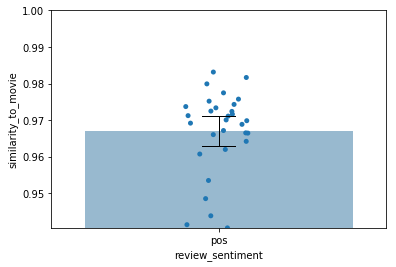

In [283]:
sns.barplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
           alpha = .5, errwidth = 0, zorder = 0)
sns.stripplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
             zorder = 1)
sns.barplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
           alpha = 0, errwidth = 1, capsize = .1, errcolor = 'k', zorder = 2)
plt.ylim([min(review_sim_results.similarity_to_movie),1])